In [1]:
]st

     Project NEOs v0.1.0
      Status `~/projects/NEOs/Project.toml`
  [a93c6f00] DataFrames v1.2.2
  [732a3c5d] EarthOrientation v0.7.1
  [5a3ac768] HORIZONS v0.3.1
  [9f4e344d] Healpix v3.0.0
  [d1acc4aa] IntervalArithmetic v0.19.0
  [4138dd39] JLD v0.12.3
  [d83715d0] PlanetaryEphemeris v0.1.0 `git@github.com:PerezHz/PlanetaryEphemeris.jl.git#main`
  [be4d8f0f] Quadmath v0.5.5
  [1a8c2f83] Query v1.0.0
  [74f56ac7] ReferenceFrameRotations v1.0.0
  [cbe49d4c] RemoteFiles v0.4.2
  [5bab7191] SPICE v0.2.2
  [6ac157d9] SatelliteToolbox v0.9.3
  [90137ffa] StaticArrays v1.2.12
  [2913bbd2] StatsBase v0.33.10
  [92b13dbe] TaylorIntegration v0.8.9
  [6aa5eb33] TaylorSeries v0.10.13
  [56f22d72] Artifacts
  [ade2ca70] Dates
  [8bb1440f] DelimitedFiles
  [8ba89e20] Distributed
  [b77e0a4c] InteractiveUtils
  [4af54fe1] LazyArtifacts
  [37e2e46d] LinearAlgebra
  [de0858da] Printf
  [8dfed614] Test


In [2]:
using Revise

In [3]:
using DataFrames, Query, TaylorSeries, PlanetaryEphemeris

In [4]:
using JLD

In [5]:
using NEOs

In [6]:
using Statistics

In [7]:
using LinearAlgebra

In [8]:
using Dates

In [9]:
using Gaston

In [10]:
using StatsBase

In [11]:
using DelimitedFiles

In [12]:
NEOs.loadjpleph()

In [13]:
## 16 ast + radial nongrav (A1 / SRP)
#dq = set_variables("δx", order=5, numvars=8)
#radec_bwd = JLD.load("radec_99942_2004_2020.dat.jld", "radec_table")
#radec_fwd = JLD.load("radec_99942_2020_2021.dat.jld", "radec_table")
#deldop_bwd = JLD.load("deldop_99942_RADAR_2005_2013.dat.jld", "deldop_table")
#deldop_fwd_ = JLD.load("deldop_99942_RADAR_2021.dat.jld", "deldop_table")

# 32 ast (NO srp)
dq = set_variables("δx", order=5, numvars=7)
radec_bwd = JLD.load("radec_99942_2004_2020_32AST.dat.jld", "radec_table")
radec_fwd = JLD.load("radec_99942_2020_2021_32AST.dat.jld", "radec_table")
deldop_bwd = JLD.load("deldop_99942_RADAR_2005_2013_32AST.dat.jld", "deldop_table")
deldop_fwd_ = JLD.load("deldop_99942_RADAR_2021_32AST.dat.jld", "deldop_table")

## 16 ast (NO srp)
#dq = set_variables("δx", order=5, numvars=7)
#radec_bwd = JLD.load("radec_99942_2004_2020_LAST_16ast.dat.jld", "radec_table")
#radec_fwd = JLD.load("radec_99942_2020_2021_LAST_16ast.dat.jld", "radec_table")
#deldop_bwd = JLD.load("deldop_99942_RADAR_2005_2013_LAST_16ast.dat.jld", "deldop_table")
#deldop_fwd_ = JLD.load("deldop_99942_RADAR_2021_LAST_16ast.dat.jld", "deldop_table")
;

In [14]:
radec_all_ = vcat(radec_bwd, radec_fwd)
radec_all = radec_all_ |> @filter( 
    (Date(_.dt_utc_obs) != Date(2021, 1, 28)) #&& (Date(_.dt_utc_obs) <= Date(2021, 3, 8))
    ) |> DataFrame
;

In [15]:
#deldop_fwd = deldop_fwd_[1:end-1,:] # in paper results, only 3 out of 4 radar measurements are used
deldop_fwd = deldop_fwd_

deldop_all = vcat(deldop_bwd, deldop_fwd)
;

In [16]:
### first and last dates (optical obs)
radec_all.dt_utc_obs[1], radec_all.dt_utc_obs[end]

(DateTime("2004-03-15T02:35:21.696"), DateTime("2021-05-12T06:28:35.904"))

In [17]:
nrow(radec_all), nrow(deldop_all)

(7902, 38)

In [18]:
del_bwd = deldop_bwd |> @filter(_.delay_index) |> DataFrame
dop_bwd = deldop_bwd |> @filter(_.doppler_index) |> DataFrame

del_fwd = deldop_fwd |> @filter(_.delay_index) |> DataFrame
dop_fwd = deldop_fwd |> @filter(_.doppler_index) |> DataFrame

del_all = deldop_all |> @filter(_.delay_index) |> DataFrame
dop_all = deldop_all |> @filter(_.doppler_index) |> DataFrame
;

In [19]:
res_τ = del_all |> @map( _.τ_obs - _.τ_comp ) |> collect
res_ν = dop_all |> @map( _.ν_obs - _.ν_comp ) |> collect

σ_del_bwd = del_bwd.σ_τ
σ_dop_bwd = dop_bwd.σ_ν

σ_del_fwd = del_fwd.σ_τ
σ_dop_fwd = dop_fwd.σ_ν

σ_del_all = del_all.σ_τ
σ_dop_all = dop_all.σ_ν

w_τ = del_all |> @map( 1/(_.σ_τ)^2 ) |> collect
w_ν = dop_all |> @map( 1/(_.σ_ν)^2 ) |> collect


# only Vokrouhlicky et al. (2015) data
res_τ_v15 = del_bwd |> @map( _.τ_obs - _.τ_comp ) |> collect
res_ν_v15 = dop_bwd |> @map( _.ν_obs - _.ν_comp ) |> collect

w_τ_v15 = del_bwd |> @map( 1/(_.σ_τ)^2 ) |> collect
w_ν_v15 = dop_bwd |> @map( 1/(_.σ_ν)^2 ) |> collect
;

In [20]:
# check if all RA/Dec observations are CCD:

all(radec_all |> @map(begin x = _.j2000; x == "C" || x == "X" end))

true

In [21]:
# there are 494 RA/Dec obs without catalog info
nrow(  radec_all |> @filter(_.catalog == " ") |> DataFrame  )

512

In [22]:
### WIP: outlier rejection

### function chisqobs(row, Γ_β, x, outlier::Bool=false)
###     A_α_TN = TaylorSeries.gradient(row.α_obs-row.α_corr-row.α_comp)
###     A_δ_TN = TaylorSeries.gradient(row.δ_obs-row.δ_corr-row.δ_comp)
###     A_i = hcat(A_α_TN(x), A_δ_TN(x))
###     outlier_sign = outlier*2-1
###     (A_i')*Γ_β*A_i
### end

### chisqobs(res0, Γ_OR7, x_OR7)

In [23]:
#radec_04XX = radec_0415
#radec_04XX = radec_0420
#radec_04XX = radec_0421
#radec_04XX = filter(x->( DateTime(x.yr, x.month, x.day) != DateTime(2021, 1, 28) ), radec_0421)
#radec_04XX = radec_0421

#radec_04XX = filter(x->x.dt_utc_obs<DateTime(2021,1,14), radec_0420)


#radec_04XX = filter(x->((x.α_obs-x.α_corr-x.α_comp())^2 + (x.δ_obs-x.δ_corr-x.δ_comp())^2)<χ2_rej, radec_04XX)
#radec_04XX = filter(x->((x.α_obs-x.α_corr-x.α_comp(x_OR7))^2 + (x.δ_obs-x.δ_corr-x.δ_comp(x_OR7))^2)/(x.σ^2) ≤ χ2_rej, radec_04XX)

In [24]:
#χ2_rej = 4.0 #4.0 #4.25 #5.025 # Brozovic et al (2018) use Chesley et al (2010) outlier rejection, in turn from Carpino et al (2003)
radec_04XX = radec_all
#radec_04XX = filter(x->((x.α_obs-x.α_corr-x.α_comp(x_OR7))^2 + (x.δ_obs-x.δ_corr-x.δ_comp(x_OR7))^2)/(x.σ^2) ≤ χ2_rej, radec_04XX)
#;

In [25]:
#nrow(radec_all), nrow(radec_04XX)

In [26]:
#radec_04XX.dt_utc_obs

In [27]:
# Vokrouhlicky et al. (2015) obs table
radec_vok15 = radec_table("../data/vokr15_mpc_formatted.dat")

# vector of RA values from Vokrouhlicky et al. (2015) observations (used for filtering)
vok15_rav = radec_vok15.α_obs

vok15_ind_filt = findall(x->x ∈ vok15_rav, radec_all.α_obs)
;

In [28]:
# Vorkouhliky et al. (2015) RA/Dec table
radec_v15 = radec_all |> @filter(_.α_obs ∈ vok15_rav) |> DataFrame;

In [29]:
radec_v15_radec_corr = radec_vok15 |> @select( :α_corr, :δ_corr ) |> DataFrame;

In [30]:
res_α = radec_04XX |> @map(_.α_obs - _.α_corr - _.α_comp) |> collect
res_δ = radec_04XX |> @map(_.δ_obs - _.δ_corr - _.δ_comp) |> collect

res_α_v15 = (radec_v15 |> @map(_.α_obs - _.α_comp)) .- radec_v15_radec_corr.α_corr
res_δ_v15 = (radec_v15 |> @map(_.δ_obs - _.δ_comp)) .- radec_v15_radec_corr.δ_corr
;

In [31]:
mean(res_α()), mean(res_δ())

(0.34691489163788025, -0.12966359996037705)

In [32]:
# read astrometric errors from Tholen et al. (2013)
tho13_errors = readdlm("../data/tholenetal2013_opterror.dat", ',')
# compute weights
w_α_tho13 = 1 ./ (tho13_errors[:,1].^2 .+ tho13_errors[:,3].^2 .+ tho13_errors[:,5].^2)
w_δ_tho13 = 1 ./ (tho13_errors[:,2].^2 .+ tho13_errors[:,4].^2 .+ tho13_errors[:,6].^2)

# Tholen et al. (2013) obs table
radec_tho13 = radec_table("../data/tholen13_mpc_formatted.dat")
# vector of RA values from Tholen et al. (2013) observations (used for filtering)
tho13_rav = radec_tho13.α_obs

tho13_ind_filt = findall(x->x ∈ tho13_rav, radec_all.α_obs)
tho13_ind_filt_v15 = findall(x->x ∈ tho13_rav, radec_v15.α_obs)
@show length(tho13_ind_filt), length(tho13_ind_filt_v15)
;

(length(tho13_ind_filt), length(tho13_ind_filt_v15)) = (432, 432)


In [33]:
function w8sfarnocchia15(row::NamedTuple)
    return w8sfarnocchia15(row.obscode, row.dt_utc_obs, row.catalog)
end

function w8sfarnocchia15(df::DataFrame)
    return w8sfarnocchia15.(df.obscode, df.dt_utc_obs, df.catalog)
end

function w8sfarnocchia15(obscode::Union{Int,String}, dt_utc_obs::DateTime, catalog::String)
    w = 1.0 # unit weight (arcseconds)
    if obscode == "H01" # Magdalena Ridge
        return 0.3w
    elseif obscode == "568" # Mauna Kea (MPEC 2014-R71)
        return 0.13w #0.2w #0.2":Verevs17 weight;0.13":Farnocchia15 weight
    elseif obscode == "F51" # PanSTARRS-PS1
        return 0.15w #0.2w #0.2":Verevs17 weight;0.15":Farnocchia15 weight
    else
        return w
    end
end


w8sfarnocchia15 (generic function with 3 methods)

In [34]:
# for each observation batch, count the number of observations made in the same night (?) by the same observatory
date_obscode_v = radec_04XX |> @map(  (Date(_.dt_utc_obs),_.obscode)  )
date_obscode_v_v15 = radec_v15 |> @map(  (Date(_.dt_utc_obs),_.obscode)  )
Nv = [count(x->x[1]==i[1] && x[2]==i[2], date_obscode_v) for i in date_obscode_v]
Nv_v15 = [count(x->x[1]==i[1] && x[2]==i[2], date_obscode_v_v15) for i in date_obscode_v_v15]
relax_factor = map(x->x>4.0 ? x/4.0 : 1.0, Nv)
relax_factor_v15 = map(x->x>4.0 ? x/5.0 : 1.0, Nv_v15) # map(x->x>2.0 ? x : 1.0, Nv_v15)

# statistical weights according to Veres et al (2017)
σ_v17 = radec_04XX.σ
σ_v17_v15 = w8sfarnocchia15(radec_v15)

w_α = 1 ./ (σ_v17.^2)
w_δ = 1 ./ (σ_v17.^2)

w_α_v15 = 1 ./ (σ_v17_v15.^2)
w_δ_v15 = 1 ./ (σ_v17_v15.^2)

# Tholen et al. (2013) astrometry uncertainties
w_α[tho13_ind_filt] .= w_α_tho13
w_δ[tho13_ind_filt] .= w_δ_tho13
w_α_v15[tho13_ind_filt_v15] .= w_α_tho13
w_δ_v15[tho13_ind_filt_v15] .= w_δ_tho13

w_α = w_α./(relax_factor)
w_δ = w_δ./(relax_factor)

w_α_v15 = w_α_v15./(relax_factor_v15)
w_δ_v15 = w_δ_v15./(relax_factor_v15)
;

In [35]:
length(w_τ), length(w_ν), length(w_α), length(w_δ)

(20, 30, 7902, 7902)

In [36]:
length(w_τ_v15), length(w_ν_v15), length(w_α_v15), length(w_δ_v15)

(17, 29, 472, 472)

In [37]:
nobs_R = nrow(del_all) + nrow(dop_all)
nobs_O = nrow(radec_04XX)
nobs = nobs_R + nobs_O
@show nobs_O, nobs_R, nobs
;

(nobs_O, nobs_R, nobs) = (7902, 50, 7952)


In [38]:
res_O = vcat(res_α, res_δ)
w_O = vcat(w_α, w_δ)

res_R = vcat(res_τ, res_ν)
w_R = vcat(w_τ, w_ν)

res_OR = vcat(res_R, res_O)
w_OR = vcat(w_R, w_O)
;

In [39]:
# only Vokrouhliky et al. (2015) data
res_O_v15 = vcat(res_α_v15, res_δ_v15)
w_O_v15 = vcat(w_α_v15, w_δ_v15)

res_R_v15 = vcat(res_τ_v15, res_ν_v15)
w_R_v15 = vcat(w_τ_v15, w_ν_v15)

res_OR_v15 = vcat(res_R_v15, res_O_v15)
w_OR_v15 = vcat(w_R_v15, w_O_v15)
;

In [40]:
# pre-2021, with SRP ("OR8")

x_OR7_v15, Γ_OR7_v15 = newtonls(res_OR_v15, w_OR_v15, zeros(get_numvars()))
σ_OR7_v15 = sqrt.(diag(Γ_OR7_v15))
@show x_OR7_v15 σ_OR7_v15 x_OR7_v15[end]/σ_OR7_v15[end]

x_OR6_v15, Γ_OR6_v15 = newtonls_6v(res_OR_v15, w_OR_v15, zeros(get_numvars()))
σ_OR6_v15 = sqrt.(diag(Γ_OR6_v15))
@show x_OR6_v15 σ_OR6_v15 x_OR6_v15[end]/σ_OR6_v15[end]

sqrt((Δx' * (C * Δx)) / npar) = 1.9640844024721462
sqrt((Δx' * (C * Δx)) / npar) = 0.769367236969942
sqrt((Δx' * (C * Δx)) / npar) = 0.9902716683393307
sqrt((Δx' * (C * Δx)) / npar) = 0.05324311121121476
sqrt((Δx' * (C * Δx)) / npar) = 0.005176729618177833
x_OR7_v15 = [-140.57822381227118, -1.8626995796263301, -5.0591050197229706, 0.41128379883273736, -2.3129699069876146, -0.8466216046493642, -4.952683388435702]
σ_OR7_v15 = [77.39075707616591, 1.1023265693697004, 3.052182042957789, 0.22712152784292372, 1.2755510276394246, 0.46570628648779244, 2.7418336471835376]
x_OR7_v15[end] / σ_OR7_v15[end] = -1.8063398534492383
sqrt((Δx' * (C * Δx)) / npar) = 2.1448188382753965
sqrt((Δx' * (C * Δx)) / npar) = 0.000981047920861629
sqrt((Δx' * (C * Δx)) / npar) = 1.971162262052317e-9
sqrt((Δx' * (C * Δx)) / npar) = 1.287994004176912e-9
sqrt((Δx' * (C * Δx)) / npar) = 9.311817242399466e-10
x_OR6_v15 = [-0.8543451179582806, -0.14485024982712327, 0.134572845623506, 0.0013068469706985508, -0.009310434184

0.0

In [41]:
# post-2021, NO SRP, 32 ast

x_OR7, Γ_OR7 = newtonls(res_OR, w_OR, zeros(get_numvars()))
σ_OR7 = sqrt.(diag(Γ_OR7))
@show x_OR7 σ_OR7 x_OR7[end]/σ_OR7[end]

x_OR6, Γ_OR6 = newtonls_6v(res_OR, w_OR, zeros(get_numvars()))
σ_OR6 = sqrt.(diag(Γ_OR6))
@show x_OR6 σ_OR6 x_OR6[end]/σ_OR6[end]
;

sqrt((Δx' * (C * Δx)) / npar) = 222.475842405106
sqrt((Δx' * (C * Δx)) / npar) = 0.2858728846213926
sqrt((Δx' * (C * Δx)) / npar) = 5.838993078280068e-7
sqrt((Δx' * (C * Δx)) / npar) = 1.2285195999026824e-8
sqrt((Δx' * (C * Δx)) / npar) = 2.834331624148975e-8
x_OR7 = [-80.81813958236799, -0.7133762366599218, -3.5612724648364917, 0.23809843716927998, -1.3416435295268134, -0.4697710231985644, -2.898835108503474]
σ_OR7 = [0.7119423491726864, 0.19425371050305715, 0.5411373135993107, 0.00479175088401477, 0.006723432346112966, 0.013798419959753073, 0.02474582241296382]
x_OR7[end] / σ_OR7[end] = -117.14442381938515
sqrt((Δx' * (C * Δx)) / npar) = 235.49546065282695
sqrt((Δx' * (C * Δx)) / npar) = 0.364126741129929
sqrt((Δx' * (C * Δx)) / npar) = 1.5211002127603424e-6
sqrt((Δx' * (C * Δx)) / npar) = 2.7252416285687694e-8
sqrt((Δx' * (C * Δx)) / npar) = 2.4352441136281672e-8
x_OR6 = [-68.76396490471303, 10.099177450970803, 38.79455427929612, 0.6438276015522235, -1.2517209716176558, -1.163286697

In [42]:
(-2.898835108503474 - -2.8988788886209065), (-2.898835108503474 - -2.8988788886209065)/0.02474582241296382

(4.3780117432667964e-5, 0.0017691922580731234)

In [43]:
# post-2021, NO SRP, 16 ast

x_OR7, Γ_OR7 = newtonls(res_OR, w_OR, zeros(get_numvars()))
σ_OR7 = sqrt.(diag(Γ_OR7))
@show x_OR7 σ_OR7 x_OR7[end]/σ_OR7[end]

x_OR6, Γ_OR6 = newtonls_6v(res_OR, w_OR, zeros(get_numvars()))
σ_OR6 = sqrt.(diag(Γ_OR6))
@show x_OR6 σ_OR6 x_OR6[end]/σ_OR6[end]
;

sqrt((Δx' * (C * Δx)) / npar) = 222.475842405106
sqrt((Δx' * (C * Δx)) / npar) = 0.2858728846213926
sqrt((Δx' * (C * Δx)) / npar) = 5.838993078280068e-7
sqrt((Δx' * (C * Δx)) / npar) = 1.2285195999026824e-8
sqrt((Δx' * (C * Δx)) / npar) = 2.834331624148975e-8
x_OR7 = [-80.81813958236799, -0.7133762366599218, -3.5612724648364917, 0.23809843716927998, -1.3416435295268134, -0.4697710231985644, -2.898835108503474]
σ_OR7 = [0.7119423491726864, 0.19425371050305715, 0.5411373135993107, 0.00479175088401477, 0.006723432346112966, 0.013798419959753073, 0.02474582241296382]
x_OR7[end] / σ_OR7[end] = -117.14442381938515
sqrt((Δx' * (C * Δx)) / npar) = 235.49546065282695
sqrt((Δx' * (C * Δx)) / npar) = 0.364126741129929
sqrt((Δx' * (C * Δx)) / npar) = 1.5211002127603424e-6
sqrt((Δx' * (C * Δx)) / npar) = 2.7252416285687694e-8
sqrt((Δx' * (C * Δx)) / npar) = 2.4352441136281672e-8
x_OR6 = [-68.76396490471303, 10.099177450970803, 38.79455427929612, 0.6438276015522235, -1.2517209716176558, -1.163286697

In [44]:
@show x_OR7 Γ_OR7

x_OR7 = [-80.81813958236799, -0.7133762366599218, -3.5612724648364917, 0.23809843716927998, -1.3416435295268134, -0.4697710231985644, -2.898835108503474]
Γ_OR7 = [0.5068619085455233 0.11940253738668327 -0.13718350564978662 -0.0006258027301194737 0.004711313157221584 0.007018795674486953 0.0025462694490050435; 0.11940253742302409 0.03773450404420553 0.011424926444151573 0.00028882755463475584 0.001031448303596345 0.0008826592369233183 0.0022840652666241846; -0.13718350545247704 0.011424926498189065 0.2928295921694788 0.0025221036026654344 -0.0014358518110172292 -0.006661406718717781 0.00894739844625755; -0.00062580272826296 0.0002888275551022986 0.0025221036024433885 2.2960876534456336e-5 -8.10583499852566e-6 -5.1875620619375085e-5 8.57076513701302e-5; 0.004711313157035527 0.001031448303206883 -0.001435851812855113 -8.105835016028152e-6 4.520454251275811e-5 6.703924234023766e-5 1.899468131578466e-5; 0.007018795670869293 0.000882659235615 -0.006661406720443044 -5.187562063967593e-5 6.703

7×7 Matrix{Float64}:
  0.506862     0.119403     -0.137184    …   0.0070188     0.00254627
  0.119403     0.0377345     0.0114249       0.000882659   0.00228407
 -0.137184     0.0114249     0.29283        -0.00666141    0.0089474
 -0.000625803  0.000288828   0.0025221      -5.18756e-5    8.57077e-5
  0.00471131   0.00103145   -0.00143585      6.70392e-5    1.89947e-5
  0.0070188    0.000882659  -0.00666141  …   0.000190396  -0.000146501
  0.00254627   0.00228407    0.0089474      -0.000146501   0.000612356

In [ ]:
#x_O7, Γ_O7 = newtonls(res_O, w_O, zeros(8))
#σ_O7 = sqrt.(diag(Γ_O7))
#@show x_O7 σ_O7 x_O7[end]/σ_O7[end]
#
#x_R7, Γ_R7 = newtonls(res_R, w_R, zeros(8))
#σ_R7 = sqrt.(diag(Γ_R7))
#@show x_R7 σ_R7 x_R7[end]/σ_R7[end]
#
#x_O6, Γ_O6 = newtonls(res_O, w_O, zeros(8))
#σ_O6 = sqrt.(diag(Γ_O6))
#@show x_O6 σ_O6 x_O6[end]/σ_O6[end]
#
#x_R6, Γ_R6 = newtonls(res_R, w_R, zeros(8))
#σ_R6 = sqrt.(diag(Γ_R6))
#@show x_R6 σ_R6 x_R6[end]/σ_R6[end]

In [45]:
#@show x_OR7 Γ_OR7

In [42]:
# 32 ast
#sqrt(Γ_OR7[7,7])

In [45]:
# 16 ast
sqrt(Γ_OR7[7,7])

0.02474582241296382

In [46]:
abs(-2.894053174513909 +2.8941071491385224)/sqrt(Γ_OR7[7,7])

0.0021811610748908275

In [47]:
#@show x_OR7 Γ_OR7

In [48]:
@show x_OR7.*vcat(1e-8ones(6), 1e-14)
;

x_OR7 .* vcat(1.0e-8 * ones(6), 1.0e-14) = [-8.081813958236799e-7, -7.133762366599218e-9, -3.561272464836492e-8, 2.3809843716928e-9, -1.3416435295268134e-8, -4.6977102319856445e-9, -2.8988351085034736e-14]


In [50]:
#@show x_OR7.*vcat(1e-8ones(6), 1e-14, 1e-13)
#;

# Fit quality statistics: $\chi^2$, normalized RMS

The gravity-only solution post-fit normalized RMS for the optical, radar, and combined optical and radar astrometry are, respectively, 0.448, 14.720 and 1.0259. Moreover, the gravity-only solution post-fit right-ascension weighted mean residual is 0.072$~$arcsec, while the declination weighted mean residual is 0.218$~$arcsec. The weighted time-delay and Doppler shift mean residual for the gravity-only solution are, respectively, -0.06 us and 0.043 Hz. On the other hand, the non-gravitational solution normalized RMS for the optical, radar, and combined optical and radar astrometry are, respectively, 0.313, 0.387 and 0.314. The right-ascension, declination, time-delay and Doppler shift weighted mean residuals, are, respectively, 0.008$~$arcsec, 0.003$~$arcsec, -0.0003$~$us and -0.31$~$Hz.

In [51]:
mean(res_α(x_OR6), weights(w_α)), mean(res_δ(x_OR6), weights(w_δ))

(0.09590496628832569, 0.08181218907367854)

In [52]:
mean(res_α(x_OR7), weights(w_α)), mean(res_δ(x_OR7), weights(w_δ))

(0.0055309987818065575, 0.0036397495750039124)

In [53]:
mean(res_τ(x_OR6), weights(w_τ)), mean(res_ν(x_OR6), weights(w_ν))

(-0.06910018018352887, 0.026201190834613388)

In [54]:
mean(res_τ(x_OR7), weights(w_τ)), mean(res_ν(x_OR7), weights(w_ν))

(-0.0002448157470529978, -0.030975129900456706)

In [55]:
nrms(res_O(x_OR6), w_O), nrms(res_R(x_OR6), w_R), nrms(res_OR(x_OR6), w_OR)

(0.48906355761487863, 15.11559177424043, 0.9792893328089622)

In [56]:
nrms(res_O(x_OR7), w_O), nrms(res_R(x_OR7), w_R), nrms(res_OR(x_OR7), w_OR)

(0.3053901525790917, 0.38648401757199513, 0.30567972379682484)

In [57]:
chi2(res_OR(x_OR7), w_OR)

1481.3992429911366

In [58]:
chi2(res_OR(x_OR6), w_OR)

15204.10644844116

In [59]:
# signal-to-noise ratio
abs(x_OR7[end]/σ_OR7[end])

117.14442381938515

# Semimajor axis drift

In [60]:
jd0 = datetime2julian(DateTime(2020,12,17)) #Julian date (TDB) of integration initial time
et0 = (jd0 - J2000)*daysec

6.614352e8

In [61]:
q00 = [-0.18034747703273316, 0.9406910666200128, 0.3457360259054398, -0.016265942170279046, 4.392889725556651e-5, -0.00039519931615139716]

6-element Vector{Float64}:
 -0.18034747703273316
  0.9406910666200128
  0.3457360259054398
 -0.016265942170279046
  4.392889725556651e-5
 -0.00039519931615139716

In [62]:
if get_numvars() == 7
    @show q00 .+ (vcat(1e-8*ones(6), 1e-14).*x_OR7)[1:6]
elseif get_numvars() == 8
    q00 .+ (vcat(1e-8*ones(6), 1e-14, 1e-13).*x_OR7)[1:6]
end

q00 .+ (vcat(1.0e-8 * ones(6), 1.0e-14) .* x_OR7)[1:6] = [-0.180348285214129, 0.9406910594862504, 0.3457359902927151, -0.016265939789294675, 4.391548082027124e-5, -0.00039520401386162915]


6-element Vector{Float64}:
 -0.180348285214129
  0.9406910594862504
  0.3457359902927151
 -0.016265939789294675
  4.391548082027124e-5
 -0.00039520401386162915

In [63]:
xas = q00 .- NEOs.kmsec2auday(NEOs.sun_pv(et0)) # .+ (vcat(1e-8*ones(6), 1e-14).*x_OR7)[1:6]

6-element Vector{Float64}:
 -0.17379952231982293
  0.9351450449312941
  0.3432198872505777
 -0.016259014389234605
  4.9169635816651055e-5
 -0.00039316391905295676

In [64]:
ϵ0_deg = 84381.448/3600;
m_eq2ecl = Rx(deg2rad(ϵ0_deg));
m_xv_eq2ecl = hcat(vcat(m_eq2ecl, zeros(3,3)), vcat(zeros(3,3), m_eq2ecl));

In [65]:
kep0 = vcat([pv2kep(  m_xv_eq2ecl*(xas .+ (vcat(1e-8*ones(6), 1e-14).*dq)[1:6])  , μ[1], jd0)...][1:6],1e-14(dq[7])); # x_OR6 +
#kep0 = vcat([pv2kep(  m_xv_eq2ecl*(xas .+ (vcat(1e-8*ones(6), 1e-14, 1e-13).*dq)[1:6])  , μ[1], jd0)...][1:6],1e-14(dq[7]),1e-13(dq[8])); # x_OR6 +
kep0()

7-element Vector{Float64}:
   0.19150886541679907
   0.7458530646657939
   2.45910104097325e6
 204.04200861628541
 126.65394416151273
   3.3367727716362747
   0.0

In [66]:
kep_OR7 = kep0(x_OR7)

7-element Vector{Float64}:
   0.1915088671476207
   0.7458530503609706
   2.4591010409253803e6
 204.04199117698067
 126.65396093863065
   3.336773201417598
  -2.8988351085034736e-14

In [67]:
# WARNING: these are ecliptic elements!!! also, not sure about the order in the Ω ↔ ω angles
kep_JPL216 = [0.1914347568286823, 0.7460634895090179, 2459424.558511739019, 203.9662692226386, 126.5900238507279, 3.338874353538208, -2.901085583204654E-14, 5.E-13]
#σ_kep_JPL204 = [2.2197e-09, 2.2003e-09, 1.2886e-06, 1.4045e-05, 1.4205e-05, 2.4295e-07, 3.039E-16]
;

In [68]:
kep_JPL216

8-element Vector{Float64}:
   0.1914347568286823
   0.7460634895090179
   2.459424558511739e6
 203.9662692226386
 126.5900238507279
   3.338874353538208
  -2.901085583204654e-14
   5.0e-13

In [69]:
orbel_OR7_TN = kep_OR7 .+ dq
#orbel_OR7_TN = kep_JPL216 .+ dq # length(kep_JPL216) == 8

7-element Vector{TaylorN{Float64}}:
        0.1915088671476207 + 1.0 δx₁ + 𝒪(‖x‖⁶)
        0.7458530503609706 + 1.0 δx₂ + 𝒪(‖x‖⁶)
      2.4591010409253803e6 + 1.0 δx₃ + 𝒪(‖x‖⁶)
        204.04199117698067 + 1.0 δx₄ + 𝒪(‖x‖⁶)
        126.65396093863065 + 1.0 δx₅ + 𝒪(‖x‖⁶)
         3.336773201417598 + 1.0 δx₆ + 𝒪(‖x‖⁶)
  - 2.8988351085034736e-14 + 1.0 δx₇ + 𝒪(‖x‖⁶)

In [70]:
var_names_str = prod(get_variable_names().*" ")
vars_old = get_variables()
vars_new = set_variables(eltype(vars_old[1]), var_names_str[1:prevind(var_names_str, end)], order=vars_old[1].order)

7-element Vector{TaylorN{Float64}}:
  1.0 δx₁ + 𝒪(‖x‖⁶)
  1.0 δx₂ + 𝒪(‖x‖⁶)
  1.0 δx₃ + 𝒪(‖x‖⁶)
  1.0 δx₄ + 𝒪(‖x‖⁶)
  1.0 δx₅ + 𝒪(‖x‖⁶)
  1.0 δx₆ + 𝒪(‖x‖⁶)
  1.0 δx₇ + 𝒪(‖x‖⁶)

In [71]:
x_OR7[7], σ_OR7[7]

(-2.898835108503474, 0.02474582241296382)

In [72]:
# OR7, 16 ast
ady_kep_au_My = 1e6yr*yarkp2adot(orbel_OR7_TN[7], orbel_OR7_TN[2]/(1.0 - orbel_OR7_TN[1]), orbel_OR7_TN[1], μ[1]) # au/Myr

 - 0.0013304567062035874 + 0.00029381274032279223 δx₁ + 0.0008919027049361038 δx₂ + 4.58962533709079e10 δx₇ - 0.001009864597577864 δx₁² - 0.00019696422786002904 δx₁ δx₂ - 1.013554511813793e10 δx₁ δx₇ - 0.0008968616919624277 δx₂² - 3.0767624633763645e10 δx₂ δx₇ + 6.0822370333661864e-5 δx₁³ + 0.0006769863025224069 δx₁² δx₂ + 3.4836910682346725e10 δx₁² δx₇ + 0.000198059350730721 δx₁ δx₂² + 6.794599226504884e9 δx₁ δx₂ δx₇ + 0.0010020536122233611 δx₂³ + 3.0938692902247665e10 δx₂² δx₇ - 0.0009024938196202712 δx₁⁴ - 4.077369550491581e-5 δx₁³ δx₂ - 2.0981659203465874e9 δx₁³ δx₇ - 0.0006807503524267604 δx₁² δx₂² - 2.3353736145133892e10 δx₁² δx₂ δx₇ - 0.00022128951388264512 δx₁ δx₂³ - 6.832377259049042e9 δx₁ δx₂² δx₇ - 0.0011755625458273549 δx₂⁴ - 3.456745812426262e10 δx₂³ δx₇ - 0.00019038038965753866 δx₁⁵ + 0.0006050077955593876 δx₁⁴ δx₂ + 3.1132982244243084e10 δx₁⁴ δx₇ + 4.100039761704641e-5 δx₁³ δx₂² + 1.406554494435017e9 δx₁³ δx₂ δx₇ + 0.0007605948116469875 δx₁² δx₂³ + 2.3483583127230667e10 

In [73]:
# OR7, 16 ast
ady_kep_m_y = 1e3au*yr*yarkp2adot(orbel_OR7_TN[7], orbel_OR7_TN[2]/(1.0 - orbel_OR7_TN[1]), orbel_OR7_TN[1], μ[1]) #m/yr

 - 199.03349030659214 + 43.953760336821745 δx₁ + 133.42674553001152 δx₂ + 6.865981777395519e15 δx₇ - 151.07359349296084 δx₁² - 29.465429091929963 δx₁ δx₂ - 1.5162559680572142e15 δx₁ δx₇ - 134.16859942997849 δx₂² - 4.602771131707908e15 δx₂ δx₇ + 9.098897092842664 δx₁³ + 101.27570935041811 δx₁² δx₂ + 5.211527659845154e15 δx₁² δx₇ + 29.62925714154035 δx₁ δx₂² + 1.0164575765449976e15 δx₁ δx₂ δx₇ + 149.90508671585832 δx₂³ + 4.628362580417454e15 δx₂² δx₇ - 135.01115373510245 δx₁⁴ - 6.099658028105567 δx₁³ δx₂ - 3.138811540591553e14 δx₁³ δx₇ - 101.83880320131794 δx₁² δx₂² - 3.493669200201656e15 δx₁² δx₂ δx₇ - 33.1044400850818 δx₁ δx₂³ - 1.0221090897728389e15 δx₁ δx₂² δx₇ - 175.86165373044346 δx₂⁴ - 5.171218130901104e15 δx₂³ δx₇ - 28.480500915804086 δx₁⁵ + 90.5078779725853 δx₁⁴ δx₂ + 4.657427852279673e15 δx₁⁴ δx₇ + 6.133572181363497 δx₁³ δx₂² + 2.1041755739099356e14 δx₁³ δx₂ δx₇ + 113.7833642878569 δx₁² δx₂³ + 3.513094032240155e15 δx₁² δx₂² δx₇ + 38.83658457980116 δx₁ δx₂⁴ + 1.141991139405373e1

In [74]:
- 198.70516356300044 - (- 198.70886945315476)

0.003705890154321878

In [75]:
t_car2kep(x) = TaylorSeries.jacobian(kep0, x)'
t_kep2ady(x, ady_kep) = TaylorSeries.gradient(ady_kep)(x)

t_kep2ady (generic function with 1 method)

In [76]:
Γ_OR7_kep = (t_car2kep(x_OR7)')*Γ_OR7*(t_car2kep(x_OR7))

7×7 Matrix{Float64}:
  2.55852e-18  -2.46884e-18   1.37622e-15  …   7.28796e-17  -2.37533e-25
 -2.46884e-18   2.38342e-18  -1.32118e-15     -6.9089e-17    2.32406e-25
  1.37622e-15  -1.32118e-15   1.36076e-12      1.70144e-13  -2.213e-22
 -1.49209e-15   1.34771e-15  -7.3443e-12      -1.46143e-12   1.16731e-21
  2.99616e-15  -2.79709e-15   8.5202e-12       1.58192e-12  -1.36379e-21
  7.28796e-17  -6.9089e-17    1.70144e-13  …   3.0289e-14   -2.69095e-23
 -2.37533e-25   2.32406e-25  -2.213e-22       -2.69095e-23   6.12356e-32

In [77]:
1e4sqrt( (t_kep2ady(kep_OR7, ady_kep_au_My)')*Γ_OR7_kep*t_kep2ady(kep_OR7, ady_kep_au_My) )

0.09509084740625703

In [78]:
sqrt( (t_kep2ady(kep_OR7, ady_kep_m_y)')*Γ_OR7_kep*t_kep2ady(kep_OR7, ady_kep_m_y) )

1.4225388295034673

In [79]:
sqrt( (t_kep2ady(kep_OR7, ady_kep_m_y)')*Γ_OR7_kep*t_kep2ady(kep_OR7, ady_kep_m_y) )

1.4225388295034673

In [80]:
t_car2kep(x_OR7)

7×7 Matrix{Float64}:
 -7.51844e-9   4.62274e-9  …  -1.7623e-6     1.24784e-8  -0.0
 -5.3184e-9    1.73528e-8      3.27114e-6    1.83302e-7  -0.0
 -2.16725e-9   6.56745e-9     -3.05377e-6   -4.93111e-7  -0.0
  5.39305e-7  -1.25364e-6     -0.000299274   2.06476e-7  -0.0
  4.87647e-7  -4.47581e-7     -0.000152639   3.03305e-6  -0.0
  1.94919e-7  -1.98102e-7  …   0.000569897  -8.15937e-6  -0.0
 -0.0         -0.0            -0.0          -0.0          1.0e-14

In [81]:
σ_OR7_kep = sqrt.(diag(Γ_OR7_kep))

7-element Vector{Float64}:
 1.5995361054039458e-9
 1.5438338586670517e-9
 1.1665163149089168e-6
 8.807569650155787e-6
 9.369897857743647e-6
 1.740373502927721e-7
 2.4745822412963823e-16

In [82]:
kep_OR7

7-element Vector{Float64}:
   0.1915088671476207
   0.7458530503609706
   2.4591010409253803e6
 204.04199117698067
 126.65396093863065
   3.336773201417598
  -2.8988351085034736e-14

In [83]:
kep_JPL216

8-element Vector{Float64}:
   0.1914347568286823
   0.7460634895090179
   2.459424558511739e6
 203.9662692226386
 126.5900238507279
   3.338874353538208
  -2.901085583204654e-14
   5.0e-13

In [84]:
σ_OR7_kep

7-element Vector{Float64}:
 1.5995361054039458e-9
 1.5438338586670517e-9
 1.1665163149089168e-6
 8.807569650155787e-6
 9.369897857743647e-6
 1.740373502927721e-7
 2.4745822412963823e-16

In [85]:
Γ_OR7_kep = (t_car2kep(x_OR7)')*Γ_OR7*(t_car2kep(x_OR7));
Γ_OR6_kep = (t_car2kep(x_OR6)[1:6,1:6]')*Γ_OR6*t_car2kep(x_OR6)[1:6,1:6];

In [86]:
jd0

2.4592005e6

In [87]:
for (x, Γ_kep, sol_str) in [(x_OR6, Γ_OR6_kep, "OR6"), (x_OR7, Γ_OR7_kep, "OR7")]
    println("* ----===OOO===--- *", sol_str)
    @show kep0(x) sqrt.(diag(Γ_kep))
end

* ----===OOO===--- *OR6
kep0(x) = [0.19150875470094428, 0.7458531603805013, 2.459101040820619e6, 204.04254376918468, 126.65331533543133, 3.3367604630013967, 0.0]
sqrt.(diag(Γ_kep)) = [1.2794913844462638e-9, 1.225296618102021e-9, 7.489896655895965e-7, 7.4378229160293445e-6, 7.577703036850366e-6, 1.358749194768207e-7]
* ----===OOO===--- *OR7
kep0(x) = [0.1915088671476207, 0.7458530503609706, 2.4591010409253803e6, 204.04199117698067, 126.65396093863065, 3.336773201417598, -2.8988351085034736e-14]
sqrt.(diag(Γ_kep)) = [1.5995361054039458e-9, 1.5438338586670517e-9, 1.1665163149089168e-6, 8.807569650155787e-6, 9.369897857743647e-6, 1.740373502927721e-7, 2.4745822412963823e-16]


In [88]:
for (x, Γ, sol_str) in [(x_OR6, Γ_OR6, "OR6"), (x_OR7, Γ_OR7, "OR7")]
    println("* ----===OOO===--- *", sol_str)
    σ_sol_ = sqrt.(diag(Γ))
    σ_sol = length(σ_sol_)==6 ? 1e-8σ_sol_[1:6] : vcat(1e-8σ_sol_[1:6], 1e-14σ_sol_[7])
    @show vcat(q00, 0).+vcat(1e-8x[1:6], 1e-14x[7]) σ_sol
end

* ----===OOO===--- *OR6
vcat(q00, 0) .+ vcat(1.0e-8 * x[1:6], 1.0e-14 * x[7]) = [-0.1803481646723822, 0.9406911676117873, 0.3457364138509826, -0.01626593573200303, 4.391638004585033e-5, -0.00039521094901836737, 0.0]
σ_sol = [7.044598756373398e-9, 1.7092349494345878e-9, 4.0260366218820135e-9, 3.311260273795786e-11, 6.679375566411458e-11, 1.2463751872121627e-10]
* ----===OOO===--- *OR7
vcat(q00, 0) .+ vcat(1.0e-8 * x[1:6], 1.0e-14 * x[7]) = [-0.180348285214129, 0.9406910594862504, 0.3457359902927151, -0.016265939789294675, 4.391548082027124e-5, -0.00039520401386162915, -2.8988351085034736e-14]
σ_sol = [7.119423491726864e-9, 1.9425371050305714e-9, 5.411373135993107e-9, 4.7917508840147706e-11, 6.723432346112966e-11, 1.3798419959753074e-10, 2.474582241296382e-16]


In [89]:
res_α_OR6 = res_α(x_OR6)
res_δ_OR6 = res_δ(x_OR6)

res_α_OR7 = res_α(x_OR7)
res_δ_OR7 = res_δ(x_OR7)
;

In [90]:
mean(res_α_OR6), std(res_α_OR6), mean(res_δ_OR6), std(res_δ_OR6)

(0.1830101128897579, 0.45690810696916023, -0.008234149739865608, 0.5979142049587484)

In [91]:
mean(res_α_OR7), std(res_α_OR7), mean(res_δ_OR7), std(res_δ_OR7)

(-0.03744780197104822, 0.36929694641419386, 0.017094568018321647, 0.37239157825345726)

# Plots: optical astrometry post-fit residuals

In [92]:
#bins_hist = -2.0:0.1:2.0
nbins_plot = 100

#h_a = fit(Histogram, res_α_OR6, bins_hist)
h_a = fit(Histogram, res_α_OR6, nbins=nbins_plot)
bc_a = midpoints(h_a.edges[1]) # bin centers
bs_a = fill(h_a.edges[1].step.hi, length(bc_a)) # bin sizes
;

#h_b = fit(Histogram, res_δ_OR6, bins_hist)
h_b = fit(Histogram, res_δ_OR6, nbins=nbins_plot)
bc_b = midpoints(h_b.edges[1]) # bin centers
bs_b = fill(h_b.edges[1].step.hi, length(bc_b)) # bin sizes

#h_c = fit(Histogram, res_α_OR7, bins_hist)
h_c = fit(Histogram, res_α_OR7, nbins=nbins_plot)
bc_c = midpoints(h_c.edges[1]) # bin centers
bs_c = fill(h_c.edges[1].step.hi, length(bc_c)) # bin sizes

#h_d = fit(Histogram, res_δ_OR7, bins_hist)
h_d = fit(Histogram, res_δ_OR7, nbins=nbins_plot)
bc_d = midpoints(h_d.edges[1]) # bin centers
bs_d = fill(h_d.edges[1].step.hi, length(bc_d)) # bin sizes
;

In [93]:
minimum(res_α_OR6), maximum(res_α_OR6)

(-3.182128085888587, 3.1626761811132145)

In [94]:
minimum(res_δ_OR6), maximum(res_δ_OR6)

(-4.083085815277837, 2.728122311782585)

In [95]:
minimum(res_α_OR7), maximum(res_α_OR7)

(-3.137159209433001, 3.117013345869079)

In [96]:
minimum(res_δ_OR7), maximum(res_δ_OR7)

(-4.3117119086345275, 2.9167692933653506)

In [97]:
mean(res_α_OR6), mean(res_δ_OR6)

(0.1830101128897579, -0.008234149739865608)

In [98]:
mean(res_α_OR7), mean(res_δ_OR7)

(-0.03744780197104822, 0.017094568018321647)

In [99]:
# use findall instead of filter, since we're looking for the indices of ZTF observations
#ztf_obs_indx = findall(x->x=="I41", radec_all.obscode)

In [100]:
#res_α_OR7[ztf_obs_indx]

In [101]:
#res_δ_OR7[ztf_obs_indx]

In [102]:
#sqrt(  mean(res_δ_OR7[ztf_obs_indx].^2 .+ res_α_OR7[ztf_obs_indx].^2)  )

In [103]:
angv = vcat(range(0, length=1000, stop=prevfloat(2pi)), 0)
sigma_factor = 3.0
σ_cos_ang = sigma_factor*cos.(angv)
σ_sin_ang = sigma_factor*sin.(angv)

cov_αδ_cholf_OR6 = cholesky(cov(hcat(res_α_OR6, res_δ_OR6)))
cov_αδ_cholf_OR7 = cholesky(cov(hcat(res_α_OR7, res_δ_OR7)))

ell_3σ_x_OR6 = mean(res_α_OR6) .+ cov_αδ_cholf_OR6.L[1,1].*σ_cos_ang .+ cov_αδ_cholf_OR6.L[1,2].*σ_sin_ang
ell_3σ_y_OR6 = mean(res_δ_OR6) .+ cov_αδ_cholf_OR6.L[2,1].*σ_cos_ang .+ cov_αδ_cholf_OR6.L[2,2].*σ_sin_ang

ell_3σ_x_OR7 = mean(res_α_OR7) .+ cov_αδ_cholf_OR7.L[1,1].*σ_cos_ang .+ cov_αδ_cholf_OR7.L[1,2].*σ_sin_ang
ell_3σ_y_OR7 = mean(res_δ_OR7) .+ cov_αδ_cholf_OR7.L[2,1].*σ_cos_ang .+ cov_αδ_cholf_OR7.L[2,2].*σ_sin_ang
;

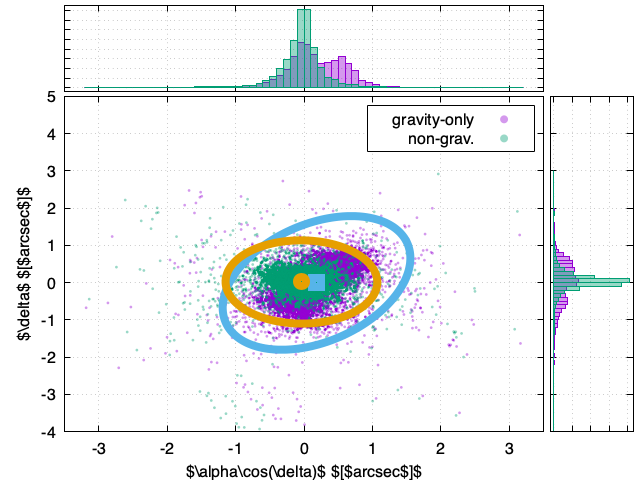

In [116]:
gap = 0.01
xlim_plt = 3.5
ymin_plt = -4.0
ymax_plt = 5.0

Gaston.set(preamble="set grid; set style circle radius 0.02")

p1 = Gaston.plot(
    bc_a,
    h_a.weights./2, 
    supp=[bs_a./2 h_a.weights./2], 
    curveconf="w boxxy notit fs transparent solid 0.4", 
    Axes(
        #linetype = :tab10,
        axesconf="set lmargin at screen 0.1; set rmargin at screen 0.85; set tmargin at screen 0.99; set bmargin at screen 0.8+$gap",
        xrange = (-xlim_plt, xlim_plt),
        format = "''"
    ),
    handle = 1
)
Gaston.plot!(
    bc_c,
    h_c.weights./2, 
    supp=[bs_c./2 h_c.weights./2], 
    curveconf="w boxxy notit fs transparent solid 0.4"
)

p2 = Gaston.plot(
    res_α_OR6, 
    res_δ_OR6, 
    curveconf="w circles fill transparent solid 0.4 noborder tit 'gravity-only'",
    Axes(
        #linetype = :tab10,
        key="at screen 0.835, screen 0.78 box spacing 1.2 height 0.4",  #"outside top right box spacing 1.2 height 1",
        axesconf="set lmargin at screen 0.1; set rmargin at screen 0.85; set tmargin at screen 0.8; set bmargin at screen 0.1",
        xrange = (-xlim_plt, xlim_plt),
        yrange = (ymin_plt, ymax_plt),
        format = "\"%g\"",
        xlabel="'\$\\alpha\\cos(\\delta)\$ \$[\$arcsec\$]\$'",
        ylabel="'\$\\delta\$ \$[\$arcsec\$]\$'"
    ), 
    handle = 2
)
Gaston.plot!(res_α_OR7, res_δ_OR7, 
    curveconf="w circles fill transparent solid 0.4 noborder tit 'non-grav.'"
)
Gaston.plot!([mean(res_α_OR6)], [mean(res_δ_OR6)], curveconf="w p pt 4 ps 1.5 lw 8") # tit 'mean R.A./Dec (OR6)'
Gaston.plot!([mean(res_α_OR7)], [mean(res_δ_OR7)], curveconf="w p pt 6 ps 1.5 lw 8") # tit 'mean R.A./Dec (OR7)'
Gaston.plot!(ell_3σ_x_OR6, ell_3σ_y_OR6, curveconf="w l lw 8 lc 3")
Gaston.plot!(ell_3σ_x_OR7, ell_3σ_y_OR7, curveconf="w l lw 8 lc 4")

p4 = Gaston.plot(
    h_b.weights./2,
    bc_b,
    supp=[h_b.weights./2 bs_b./2],
    curveconf="w boxxy notit fs transparent solid 0.4",
    Axes(
        #linetype = :tab10,
        axesconf="set lmargin at screen 0.85+$gap; set rmargin at screen 0.99; set tmargin at screen 0.8; set bmargin at screen 0.1",
        yrange = (ymin_plt, ymax_plt),
        format = "''"
    ),
    handle = 4
)
Gaston.plot!(
    h_d.weights./2,
    bc_d,
    supp=[h_d.weights./2 bs_d./2],
    curveconf="w boxxy notit fs transparent solid 0.4"
)

Gaston.plot([p1 nothing ; p2 p4])

#Gaston.save(term = "cairolatex", output = "radec_hist_NEW_SANSSERIF.tex", saveopts = "pdf standalone color dashed transparent size 7in,5in font ',14'")
#run(`pdflatex radec_hist_NEW_SANSSERIF.tex`)

In [117]:
length(res_α)

7902

In [118]:
mean(w_α.*res_α(x_OR7)), std(w_α.*res_α(x_OR7))

(0.008934276395781031, 1.1869873002946274)

In [119]:
mean(w_δ.*res_δ(x_OR7)), std(w_δ.*res_δ(x_OR7))

(0.008937100457855082, 0.8586947146735813)

In [120]:
mean(res_τ(x_OR7)), std(res_τ(x_OR7))

(-0.06122007765940242, 0.2926540688273816)

In [121]:
mean(res_ν(x_OR7)), std(res_ν(x_OR7))

(-0.024692059275373126, 0.0622351038769055)

## OR6

In [122]:
mean(res_τ(x_OR6)), std(res_τ(x_OR6))

(-16.113764856196426, 71.85630400172278)

In [123]:
mean(res_ν(x_OR6)), std(res_ν(x_OR6))

(0.04852791536752542, 0.247142244843247)

In [124]:
ind_del_0506 = 1:2
ind_del_1213 = 3:17
ind_del_2121 = 18:20 #18:19

ind_dop_0506 = 1:5
ind_dop_1213 = 6:29
ind_dop_2121 = 30:30
;

In [125]:
del_index = findall(x->x, deldop_all.delay_index)
dop_index = findall(x->x, deldop_all.doppler_index)
length(del_index), length(dop_index)

(20, 30)

In [126]:
nrow(deldop_all)

38

In [127]:
del_dates_plot_ = (deldop_all |> @filter(_.delay_index) |> DataFrame).dt_utc_obs
dop_dates_plot_ = (deldop_all |> @filter(_.doppler_index) |> DataFrame).dt_utc_obs

del_dates_plot = Dates.format.(del_dates_plot_, "dd/mm/yy HHMM")
dop_dates_plot = Dates.format.(dop_dates_plot_, "dd/mm/yy HHMM")

length(del_dates_plot), length(dop_dates_plot)

(20, 30)

# Plots: radar astrometry post-fit residuals

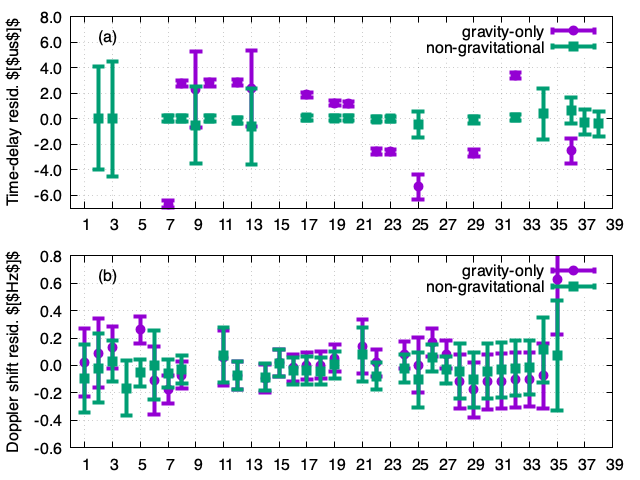

In [128]:
p1 = Gaston.plot(
    del_index,
    res_τ(x_OR6),
    supp = σ_del_all,
    key="box spacing 1.2 height 0.4", #at screen 0.835, screen 0.78 
    curveconf = "u 1:2:3 w errorbars pt 6 lw 4 tit 'gravity-only'",
    Axes(
        #axesconf="set lmargin at screen 0.15; set rmargin at screen 0.95; set bmargin at screen 0.5",
        axesconf="set lmargin at screen 0.11",
        #linetype = :tab10,
        bars = 2,
        ylabel = "'Time-delay resid. \$[\$us\$]\$'",
        xrange = (0,39),
        xtics = "1,2,40",
        format = "y '%1.1f'",
        yrange=(-7,8),
        label="1 '(a)' at graph 0.05,0.9"#,
        #title = "'gravity-only'"
    ),
    handle = 1
)
Gaston.plot!(
    del_index,
    res_τ(x_OR7),
    supp = σ_del_all,
    curveconf = "u 1:2:3 w errorbars pt 4 lw 4 tit 'non-gravitational'",
    lc = 2
)

p2 = Gaston.plot(
    dop_index,
    res_ν(x_OR6),
    supp = σ_dop_all,
    curveconf = "u 1:2:3 w errorbars pt 6 lw 4 tit 'gravity-only'",
    key="box spacing 1.2 height 0.4",
    Axes(
        #axesconf="set lmargin at screen 0.15; set rmargin at screen 0.95; set tmargin at screen 0.5",
        axesconf="set lmargin at screen 0.11",
        #linetype = :tab10,
        bars = 2,
        ylabel = "'Doppler shift resid. \$[\$Hz\$]\$'",
        xrange = (0,39),
        xtics = "1,2,40",
        format = "y '%1.1f'",
        yrange=(-0.6,0.8),
        label="1 '(b)' at graph 0.05,0.9" #,
        # title = "'non-gravitational'"
    ),
    handle = 2
)
Gaston.plot!(
    dop_index,
    res_ν(x_OR7),
    supp = σ_dop_all,
    curveconf = "u 1:2:3 w errorbars pt 4 lw 4 tit 'non-gravitational'",
    lc = 2
)


Gaston.plot([p1; p2])

#Gaston.save(term = "cairolatex", output = "deldop_residuals.tex", saveopts = "pdf standalone color dashed transparent size 10in,7in font ',14'")
#run(`pdflatex deldop_residuals.tex`)

In [129]:
deldop_dates_plot_xaxis = vcat("01/06/04 0000", del_dates_plot, "31/03/21 2359");

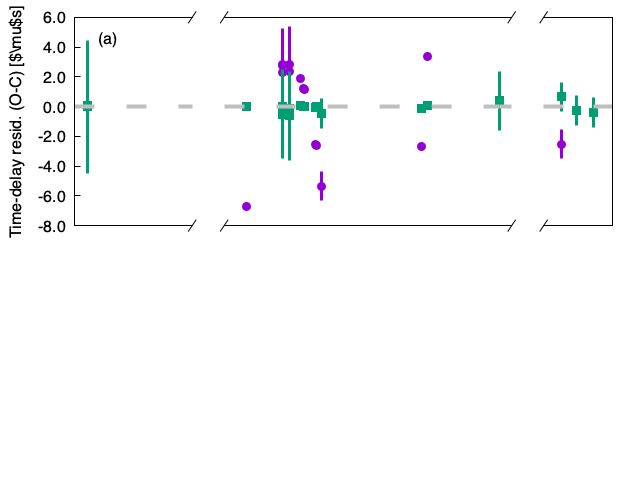

In [130]:
tmargin_bmargin_gap = 0.03
bmargin_ths_plt = 0.5 + tmargin_bmargin_gap
tmargin_ths_plt = 0.965
axsbrk_v = 1.25*0.01
axsbrk_h = 1.25*0.005
lw_ths_plt = 3
rmargin_ths_plt = 0.3

p1 = Gaston.plot(
    del_dates_plot,
    res_τ(x_OR6),
    supp = σ_del_all,
    curveconf = "u 1:3:4 w errorbars pt 6 lw $lw_ths_plt",
    Axes(
        #linetype = :tab10,
        axesconf = "set rmargin at screen 0.3; set tmargin at screen $tmargin_ths_plt; set bmargin at screen $bmargin_ths_plt",
        xdata   = "time",
        timefmt = "'%d/%m/%y %H%M'",
        xtics = false, #"format '' time (\"01/01/05\",\"01/01/06\")", # '%d/%b/%y'
        xrange = "[\"01/12/04\":\"30/05/06\"]",
        #xlabel  = "\"Date\"",
        bars = false, #2,
        ylabel = "'Time-delay resid. (O-C) [\$\\mu\$s]'",
        border = "1+2+4",
        ytics = ["nomirror", "format '%1.1f'"],
        yrange = "[-8.0:6.0]",
        arrow = [
            "from screen 0.3-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.3+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.3-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.3+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead"
            ],
        label="1 '(a)' at graph 0.2,0.9",
        grid=false
        #arrow = "from screen 0.3-0.01,1.0-0.01 to screen 0.3+0.01,1.0+0.01 nohead"
        #format = "x ''"
        #title = "'Time-delay resid. (O-C)'"
    ),
    handle = 1
)
Gaston.plot!(
    del_dates_plot,
    res_τ(x_OR7),
    supp = σ_del_all,
    curveconf = "u 1:3:4 w errorbars pt 4 lw $lw_ths_plt",
    lc = 2
)
Gaston.plot!(deldop_dates_plot_xaxis, zeros(length(deldop_dates_plot_xaxis)), curveconf=" u 1:3 w l lc rgb 'gray' lw 4 dt 2")

p2 = Gaston.plot(
    del_dates_plot,
    res_τ(x_OR6),
    supp = σ_del_all,
    curveconf = "u 1:3:4 w errorbars pt 6 lw $lw_ths_plt",
    Axes(
        #linetype = :tab10,
        xdata   = "time",
        timefmt = "'%d/%m/%y %H%M'",
        axesconf = "set lmargin at screen 0.35; set tmargin at screen $tmargin_ths_plt; set rmargin at screen 0.8; set bmargin at screen $bmargin_ths_plt",
        xtics = false, #"format '' time (\"01/01/13\",\"01/02/13\",\"01/03/13\")", # '%d/%b/%y'
        xrange = "[\"15/12/12\":\"20/03/13\"]",
        #xlabel  = "\"Date\"",
        bars = false, #2,
        #tics="scale 0",
        ytics = false, #[false, "(\"\" 0)"], #"nomirror",
        border = "1+4",
        yrange = "[-8.0:6.0]",
        format = ["x ''", "y ''"], #%1.1f
        arrow = [
            "from screen 0.35-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.35+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.35-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.35+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.80-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.80+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.80-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.80+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead"
            ],
        #ylabel = "'[us]'"
    ),
    handle = 2
)
Gaston.plot!(
    del_dates_plot,
    res_τ(x_OR7),
    supp = σ_del_all,
    curveconf = "u 1:3:4 w errorbars pt 4 lw $lw_ths_plt",
    lc = 2
)
Gaston.plot!(deldop_dates_plot_xaxis, zeros(length(deldop_dates_plot_xaxis)), curveconf=" u 1:3 w l lc rgb 'gray' lw 4 dt 2")

p3 = Gaston.plot(
    del_dates_plot,
    res_τ(x_OR6),
    supp = σ_del_all,
    curveconf = "u 1:3:4 w errorbars pt 6 lw $lw_ths_plt",
    Axes(
        #linetype = :tab10,
        xdata   = "time",
        timefmt = "'%d/%m/%y %H%M'",
        axesconf = "set lmargin at screen 0.85; set tmargin at screen 0.965; set bmargin at screen $bmargin_ths_plt",
        xtics = false, #"format '' time (\"03/03/21\",\"11/03/21\")", #'%d/%b/%y'
        xrange = "[\"02/03/21\":\"15/03/21\"]",
        #xlabel = "\"Date\"",
        bars = false, #2,
        #tics="scale 0",
        ytics = false, #[false, "(\"\" 0)"], #"nomirror",
        border = "1+4+8",
        yrange = "[-8.0:6.0]",
        format = ["x ''", "y ''"], #%1.1f
        arrow = [
            "from screen 0.85-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.85+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.85-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.85+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead"
            ],
        #ylabel = "'[us]'"
    ),
    handle = 3
)
Gaston.plot!(
    del_dates_plot,
    res_τ(x_OR7),
    supp = σ_del_all,
    curveconf = "u 1:3:4 w errorbars pt 4 lw $lw_ths_plt",
    lc = 2
)
Gaston.plot!(deldop_dates_plot_xaxis, zeros(length(deldop_dates_plot_xaxis)), curveconf=" u 1:3 w l lc rgb 'gray' lw 4 dt 2")

Gaston.plot([p1 p2 p3])

#Gaston.save(term = "cairolatex", output = "del_resids.tex", saveopts = "pdf standalone color dashed transparent size 10in,7in font ',14'")
#run(`pdflatex del_resids.tex`)

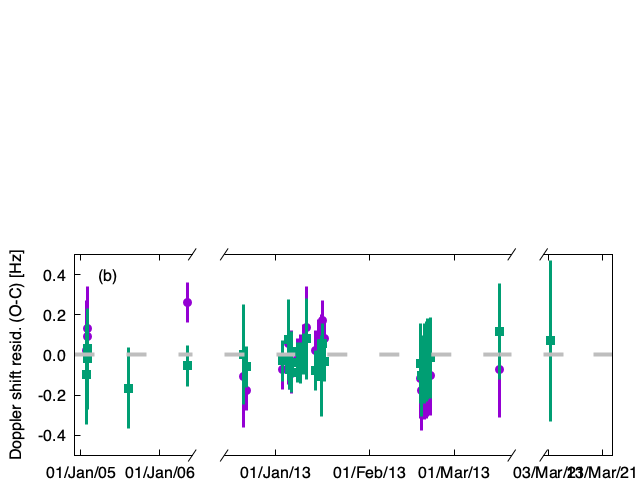

In [131]:
tmargin_ths_plt = 0.5 - tmargin_bmargin_gap
bmargin_ths_plt = 0.05

Gaston.set(preamble="unset grid")
p4 = Gaston.plot(
    dop_dates_plot,
    res_ν(x_OR6),
    supp = σ_dop_all,
    curveconf = "u 1:3:4 w errorbars pt 6 lw $lw_ths_plt",
    Axes(
        #linetype = :tab10,
        axesconf="set rmargin at screen $rmargin_ths_plt; set tmargin at screen $tmargin_ths_plt; set bmargin at screen $bmargin_ths_plt",
        xdata   = "time",
        timefmt = "'%d/%m/%y %H%M'",
        xtics = "format '%d/%b/%y' time (\"01/01/05\",\"01/01/06\")",
        xrange = "[\"01/12/04\":\"30/05/06\"]",
        #xlabel  = "\"Date\"",
        bars = false,#2,
        ylabel = "'Doppler shift resid. (O-C) [Hz]'",
        border="1+2+4",
        ytics = ["nomirror", "format '%1.1f'"],
        yrange="[-0.5:0.5]",
        arrow = [
            "from screen 0.3-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.3+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.3-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.3+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead"
            ],
        label="1 '(b)' at graph 0.2,0.9"
        #title = "'Doppler shift resid. (O-C)'"
    ),
    handle = 4
)
Gaston.plot!(
    dop_dates_plot,
    res_ν(x_OR7),
    supp = σ_dop_all,
    curveconf = "u 1:3:4 w errorbars pt 4 lw $lw_ths_plt",
    lc = 2
)
Gaston.plot!(deldop_dates_plot_xaxis, zeros(length(deldop_dates_plot_xaxis)), curveconf=" u 1:3 w l lc rgb 'gray' lw 4 dt 2")

p5 = Gaston.plot(
    dop_dates_plot,
    res_ν(x_OR6),
    supp = σ_dop_all,
    curveconf = "u 1:3:4 w errorbars pt 6 lw $lw_ths_plt",
    Axes(
        #linetype = :tab10,
        xdata   = "time",
        timefmt = "'%d/%m/%y %H%M'",
        axesconf="set lmargin at screen $rmargin_ths_plt+0.05; set rmargin at screen 0.8; set tmargin at screen $tmargin_ths_plt; set bmargin at screen $bmargin_ths_plt",
        xtics="format '%d/%b/%y' time (\"01/01/13\",\"01/02/13\",\"01/03/13\")",
        xrange="[\"15/12/12\":\"20/03/13\"]",
        #xlabel  = "\"Date\"",
        bars = false, #2,
        ytics=false,
        border="1+4",
        yrange="[-0.5:0.5]",
        arrow = [
            "from screen 0.35-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.35+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.35-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.35+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.8-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.8+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.8-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.8+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead"
            ],
        #ylabel = "'[Hz]'"
    ),
    handle = 5
)
Gaston.plot!(
    dop_dates_plot,
    res_ν(x_OR7),
    supp = σ_dop_all,
    curveconf = "u 1:3:4 w errorbars pt 4 lw $lw_ths_plt",
    lc = 2
)
Gaston.plot!(deldop_dates_plot_xaxis, zeros(length(deldop_dates_plot_xaxis)), curveconf=" u 1:3 w l lc rgb 'gray' lw 4 dt 2")

p6 = Gaston.plot(
    dop_dates_plot,
    res_ν(x_OR6),
    supp = σ_dop_all,
    curveconf = "u 1:3:4 w errorbars pt 6 lw $lw_ths_plt",
    Axes(
        #linetype = :tab10,
        xdata   = "time",
        timefmt = "'%d/%m/%y %H%M'",
        axesconf="set lmargin at screen 0.85; set tmargin at screen $tmargin_ths_plt; set bmargin at screen $bmargin_ths_plt",
        xtics="format '%d/%b/%y' time (\"03/03/21\",\"13/03/21\")",
        xrange="[\"02/03/21\":\"15/03/21\"]",
        #xlabel  = "\"Date\"",
        bars = false, #2,
        #format="y ''",
        ytics=false,
        border="1+4+8",
        yrange="[-0.5:0.5]",
        arrow = [
            "from screen 0.85-$axsbrk_h,$tmargin_ths_plt-$axsbrk_v to screen 0.85+$axsbrk_h,$tmargin_ths_plt+$axsbrk_v nohead",
            "from screen 0.85-$axsbrk_h,$bmargin_ths_plt-$axsbrk_v to screen 0.85+$axsbrk_h,$bmargin_ths_plt+$axsbrk_v nohead"
            ],
        #ylabel = "'[Hz]'"
    ),
    handle = 6
)
Gaston.plot!(
    dop_dates_plot,
    res_ν(x_OR7),
    supp = σ_dop_all,
    curveconf = "u 1:3:4 w errorbars pt 4 lw $lw_ths_plt",
    lc = 2
)
Gaston.plot!(deldop_dates_plot_xaxis, zeros(length(deldop_dates_plot_xaxis)), curveconf=" u 1:3 w l lc rgb 'gray' lw 4 dt 2")

Gaston.plot([p4 p5 p6])

#Gaston.save(term = "cairolatex", output = "dop_resids.tex", saveopts = "pdf standalone color dashed transparent size 10in,7in font ',14'")
#run(`pdflatex dop_resids.tex`)

In [133]:
Gaston.plot([p1 p2 p3; p4 p5 p6])

Gaston.save(term = "cairolatex", output = "deldop_residuals_dates_NEW_SANSSERIF.tex", saveopts = "pdf standalone color dashed transparent size 10in,7in font ',14'")
run(`pdflatex deldop_residuals_dates_NEW_SANSSERIF.tex`)

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./deldop_residuals_dates_NEW_SANSSERIF.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/minimal.cls
Document Class: minimal 2001/05/25 Standard LaTeX minimal class
) (/usr/local/texlive/2020/texmf-dist/tex/latex/extsizes/size14.clo)
(/usr/local/texlive/2020/texmf-dist/tex/latex/tools/calc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/color.sty
(/usr/

Process(`pdflatex deldop_residuals_dates_NEW_SANSSERIF.tex`, ProcessExited(0))

# $\Gamma$ matrix eigenvalues/vectors

In [45]:
Hermitian(Γ_OR7) - Γ_OR7

8×8 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0           0.0         0.0
  4.16556e-10   0.0           0.0              0.0           0.0         0.0
  7.41766e-10   1.023e-10     0.0              0.0           0.0         0.0
 -4.63088e-12  -3.82079e-12  -5.531e-12        0.0           0.0         0.0
 -6.73996e-12  -6.01791e-12  -9.06659e-12      0.0           0.0         0.0
  1.16962e-11   3.63038e-12   3.43675e-12  …   0.0           0.0         0.0
  8.39457e-12  -9.51664e-12  -1.87687e-11     -3.40827e-13   0.0         0.0
 -4.04559e-8   -1.46739e-8   -1.58527e-8      -6.72555e-11  -1.20892e-9  0.0

In [46]:
norm(Hermitian(Γ_OR7) - Γ_OR7)

4.588766203044517e-8

In [47]:
Γ_OR7_cholf = cholesky(Hermitian(Γ_OR7))

Cholesky{Float64, Matrix{Float64}}
U factor:
8×8 UpperTriangular{Float64, Matrix{Float64}}:
 0.752234  0.054979  -0.41847    0.000511845  …  0.00147843    12.0307
  ⋅        0.371432   0.725277  -0.00289847      0.0110386    -34.0141
  ⋅         ⋅         0.355482   0.00505045      0.0165342      6.91759
  ⋅         ⋅          ⋅         0.00247201      0.00358721     6.22233
  ⋅         ⋅          ⋅          ⋅              0.00737121     0.00254605
  ⋅         ⋅          ⋅          ⋅           …  0.000135268    0.126605
  ⋅         ⋅          ⋅          ⋅              0.0135124      0.0698381
  ⋅         ⋅          ⋅          ⋅               ⋅             0.00411503

In [48]:
Γ_OR7_cU = Γ_OR7_cholf.U
Γ_OR7_cL = Γ_OR7_cholf.L

8×8 LowerTriangular{Float64, Matrix{Float64}}:
  0.752234        ⋅          …   ⋅            ⋅          ⋅ 
  0.054979       0.371432        ⋅            ⋅          ⋅ 
 -0.41847        0.725277        ⋅            ⋅          ⋅ 
  0.000511845   -0.00289847      ⋅            ⋅          ⋅ 
  0.00897665    -0.00582209      ⋅            ⋅          ⋅ 
  0.00683826     0.00804182  …  0.00177787    ⋅          ⋅ 
  0.00147843     0.0110386      0.000135268  0.0135124   ⋅ 
 12.0307       -34.0141         0.126605     0.0698381  0.00411503

In [49]:
# Compute nominal initial condition in au, au/day, au/day^2
q0_OR7 = [
    -0.18034747703273316,
    0.9406910666200128,
    0.3457360259054398,
    -0.016265942170279046,
    4.392889725556651e-5,
    -0.00039519931615139716,
    0.0, 0.0
] .+ vcat(1e-8ones(6), 1e-14, 1e-13).*x_OR7
@show q0_OR7
;

q0_OR7 = [-0.18034828623950797, 0.9406910608004124, 0.3457359932221028, -0.0162659398052771, 4.391544636661421e-5, -0.00039520398300021546, -2.896514988676593e-14, -1.4916918417716468e-12]


In [50]:
# relative scalings analogous to Milani (2005)
scaling_milani_2005 = vcat(  (1/norm(q0_OR7[1:3]))*ones(3), (1/norm(q0_OR7[4:6]))*ones(3), 1/norm(q0_OR7[7]), 1/norm(q0_OR7[8])  )

# jet transport propagation scaling
jt_scaling = vcat(1e-8ones(6), 1e-14, 1e-13)
;

In [51]:
# compute cov matrix with relative scalings
Γ_OR7_scm05 = diagm(scaling_milani_2005) * ( diagm(jt_scaling)*Γ_OR7*diagm(jt_scaling) ) * diagm(scaling_milani_2005)

8×8 Matrix{Float64}:
  5.45688e-17   3.9883e-18   -3.03568e-17  …   3.77048e-12   5.95777e-9
  3.9883e-18    1.35959e-17   2.37602e-17      1.41762e-11  -7.88178e-9
 -3.03568e-17   2.37602e-17   7.98018e-17      4.49727e-11  -1.79361e-8
  2.32381e-18  -6.32782e-18  -3.1447e-18       1.29718e-11   6.3889e-9
  4.07547e-17  -1.00731e-17  -4.57552e-17     -6.49876e-12   1.29015e-8
  3.10462e-17   2.02969e-17  -6.13907e-18  …  -2.14145e-11  -1.18498e-8
  3.77048e-12   1.41762e-11   4.49727e-11      7.71437e-5   -0.00509184
  5.95777e-9   -7.88178e-9   -1.79361e-8      -0.00509184    6.23909

In [52]:
# compute normal matrix with relative scalings
C_OR7_scm05 = inv(Γ_OR7_scm05)

8×8 Matrix{Float64}:
  4.17076e22  -2.1932e23   -7.88498e22  …   7.51873e14  -7.48594e14
 -2.1932e23    1.15386e24   4.14938e23     -3.95414e15   3.93913e15
 -7.88498e22   4.14938e23   1.49237e23     -1.42165e15   1.41669e15
  2.12033e23  -1.11574e24  -4.01273e23      3.82285e15  -3.80928e15
 -2.43929e20   1.1331e21    3.80274e20     -4.32835e12   3.68179e12
  5.78128e21  -3.04283e22  -1.09429e22  …   1.04255e14  -1.03885e14
  7.51873e14  -3.95414e15  -1.42165e15      1.3591e7    -1.34968e7
 -7.48594e14   3.93913e15   1.41669e15     -1.34968e7    1.34486e7

In [53]:
# compute eigenvalues, eigenvectors of normal matrix with relative scalings
C_eig_OR7_scm05 = eigen(C_OR7_scm05)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
8-element Vector{Float64}:
     0.16027974083022423
 13700.866240137968
     7.779147349061473e15
     6.394856241153186e16
     6.672432289643891e17
     3.469395090264604e18
     1.2004977954323472e20
     2.4244984543340955e24
vectors:
8×8 Matrix{Float64}:
  9.54908e-10  -1.18277e-7   -0.579494     …   0.489088     0.131113
 -1.26329e-9   -1.06095e-7   -0.114986        -0.420935    -0.689862
 -2.8748e-9    -4.1561e-7     0.287633         0.260036    -0.248093
  1.02401e-9   -2.49163e-7    0.119643        -0.434592     0.667097
  2.06785e-9   -5.52215e-8   -0.342022        -0.571378    -0.000660596
 -1.89927e-9    4.25897e-7   -0.661014     …  -0.0254142    0.0181931
 -0.000816128  -1.0          -3.31251e-7       7.74969e-9   2.36387e-9
  1.0          -0.000816128   2.93933e-10      1.33336e-9  -2.35518e-9

In [54]:
# k₁ * V₁ = 1/√λ₁ * V₁
k1_V1 = C_eig_OR7_scm05.vectors[:,1]/sqrt(C_eig_OR7_scm05.values[1])

8-element Vector{Float64}:
  2.385186733145141e-9
 -3.1554685805226565e-9
 -7.180715231230462e-9
  2.5577873010071103e-9
  5.1651078588300255e-9
 -4.744034406697102e-9
 -0.002038539197773416
  2.497816554521262

In [55]:
# revert eigenvector of "weak" direction to JT scaling
( k1_V1 ./ scaling_milani_2005 ) ./ jt_scaling

8-element Vector{Float64}:
  0.2428863363656864
 -0.321325031868498
 -0.7312205752121796
  0.0041617244034487235
  0.008404043375332229
 -0.007718923208891495
 -0.005904659341355457
 37.259725766215304

In [56]:
Taylor1(10) * ( k1_V1 ./ scaling_milani_2005 )

8-element Vector{Taylor1{Float64}}:
     2.428863363656864e-9 t + 𝒪(t¹¹)
  - 3.2132503186849797e-9 t + 𝒪(t¹¹)
   - 7.312205752121797e-9 t + 𝒪(t¹¹)
    4.161724403448724e-11 t + 𝒪(t¹¹)
    8.404043375332229e-11 t + 𝒪(t¹¹)
  - 7.718923208891495e-11 t + 𝒪(t¹¹)
  - 5.904659341355457e-17 t + 𝒪(t¹¹)
   3.7259725766215305e-12 t + 𝒪(t¹¹)

In [57]:
@show ( ( k1_V1 ./ scaling_milani_2005 )  )  #./ jt_scaling

k1_V1 ./ scaling_milani_2005 = [2.428863363656864e-9, -3.2132503186849797e-9, -7.312205752121797e-9, 4.161724403448724e-11, 8.404043375332229e-11, -7.718923208891495e-11, -5.904659341355457e-17, 3.7259725766215305e-12]


8-element Vector{Float64}:
  2.428863363656864e-9
 -3.2132503186849797e-9
 -7.312205752121797e-9
  4.161724403448724e-11
  8.404043375332229e-11
 -7.718923208891495e-11
 -5.904659341355457e-17
  3.7259725766215305e-12

In [58]:
σ_OR7

8-element Vector{Float64}:
  0.7522338880632442
  0.37547851319746384
  0.9096766814739202
  0.00634672400532853
  0.010762551850102919
  0.01581070641087624
  0.025440518219777712
 37.25972595006995

In [59]:
@show x_OR7 .* jt_scaling

x_OR7 .* jt_scaling = [-8.092067748142685e-7, -5.819600314656928e-9, -3.26833370065447e-8, 2.3650019466660918e-9, -1.345088895229519e-8, -4.666848818306236e-9, -2.896514988676593e-14, -1.4916918417716468e-12]


8-element Vector{Float64}:
 -8.092067748142685e-7
 -5.819600314656928e-9
 -3.26833370065447e-8
  2.3650019466660918e-9
 -1.345088895229519e-8
 -4.666848818306236e-9
 -2.896514988676593e-14
 -1.4916918417716468e-12

In [60]:
#@show Γ_OR7